In [299]:
import os
import sys
import glob
import pickle
import itertools
import random
import copy

from IPython.display import Image

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib.colors import ListedColormap
from scipy.stats import multivariate_normal

import numpy as np
import pandas as pd
from scipy.stats import beta
from scipy.stats import norm

from flowMP import *

random.seed(1234)
%matplotlib inline

In [300]:
def logP_Mondrian_Gaussian_perturbation(indiv_mp,template_mp,stepsize):
    """
    To-do: truncated Gaussian pdf
    """
    if template_mp[1] == None and template_mp[2] == None:
        return 0
    
    # find the dimension and location of first cut in the old_sample
    for _ in range(template_mp[0].shape[0]):
        if template_mp[0][_,1] > template_mp[1][0][_,1]:
            break
    
    dim = _
    pos_template = template_mp[1][0][dim,1]
    pos_indiv = indiv_mp[1][0][dim, 1]
    
    res = norm(pos_template,(template_mp[0][dim,1] - template_mp[0][dim,0])*stepsize).logpdf(pos_indiv)
    
    res += logP_Mondrian_Gaussian_perturbation(indiv_mp[1],template_mp[1],stepsize)
    res += logP_Mondrian_Gaussian_perturbation(indiv_mp[2],template_mp[2],stepsize)
    return res


### function for computing joint probability
def joint_logP_Random_Effect(template_mp, indiv_mp_list, data_list, table, stepsize):
    """
    INPUT:
    template_mp: one mondrian process
    indiv_mp_list: a list of mondrian processes
    data_list: a list of cell*marker np array
    table: +1 -1 0 information
    """
    logP = comp_log_p_prior(template_mp, table, [1 for _ in range(table.shape[1])])
    n_sample = len(data_list)
    for _ in range(n_sample):
        logP += logP_Mondrian_Gaussian_perturbation(indiv_mp_list[_], template_mp, stepsize)
        logP += comp_log_p_sample(indiv_mp_list[_], data_list[_])
    return logP


## a mini MCMC run to initialize Mondrian process with data
def init_mp(theta_space, table, data, n_iter,mcmc_gaussin_std):
    # randomly draw a template mondrian process
    sample = draw_informed_Mondrian(theta_space, table)
    log_p_sample = comp_log_p_sample(sample, data) + \
                         comp_log_p_prior(sample, table, [1 for _ in range(table.shape[1])])

    for idx in xrange(n_iter):
        new_sample = Mondrian_Gaussian_perturbation(theta_space,sample, mcmc_gaussin_std)
        # perform accept-reject step
        new_log_p_sample = comp_log_p_sample(new_sample, data) + \
                            comp_log_p_prior(new_sample, table, [1 for _ in range(table.shape[1])])

        if new_log_p_sample >=  log_p_sample or \
            np.log(np.random.uniform(low=0, high=1.)) <= new_log_p_sample - log_p_sample:
            sample = new_sample
            log_p_sample = new_log_p_sample
    return sample

In [301]:
# load AML data and table
##### X: np.array, flow cytometry data, arcsin transformed
##### T: table of expert knowledge

np.random.seed(1234)
PATH = '/home/disij/projects/acdc/data/'

### LOAD DATA ###
path = PATH + 'AML_benchmark/'
df = pd.read_csv( path + 'AML_benchmark.csv.gz', sep=',', header = 0, compression = 'gzip', engine='python')
table = pd.read_csv(path + 'AML_table.csv', sep=',', header=0, index_col=0)
print table.shape

### PROCESS: discard ungated events ###
df = df[df.cell_type != 'NotGated']
df = df.drop(['Time', 'Cell_length','file_number', 'event_number', 'DNA1(Ir191)Di',
              'DNA2(Ir193)Di', 'Viability(Pt195)Di', 'subject'], axis = 1)
channels = [item[:item.find('(')] for item in df.columns[:-1]]
df.columns = channels + ['cell_type']
df = df.loc[df['cell_type'] != 'NotDebrisSinglets']
table = table.fillna(0)
X = df[channels].values
table_headers = list(table)
# df2 = pd.DataFrame([[0]*table.shape[1]], columns=table.columns, index =['unknown'])
# table = table.append(df2)

### transform data
#data = np.arcsinh((X-1.)/5.)
data = X
theta_space = np.array([[data[:,d].min(), data[:,d].max()] for d in range(data.shape[1])])


cell_type_name2idx = {x:i for i,x in enumerate(table.index)}
Y = np.array([cell_type_name2idx[_] for _ in df.cell_type])

(14, 32)


In [302]:
print table.columns[19]

CD7


## Experiment #1: 2D Simulation

Let's now test out the idea on a 2D subset of the data: the *CD4* and *CD8* features.

In [7]:
df_2d = [None for _ in range(3)]
df_2d[0] = df.loc[df['cell_type'].isin(['Monocytes'])]
df_2d[1] = df.loc[df['cell_type'].isin(['CD16- NK cells'])]
df_2d[2] = df.loc[df['cell_type'].isin(['CD16+ NK cells'])]
data_2d_list = [None for _ in range(3)]
for i in range(3):
    data_2d_list[i] = df_2d[i][channels].values
    data_2d_list[i] = np.hstack([data_2d_list[i][:,21][np.newaxis].T, data_2d_list[i][:,19][np.newaxis].T])

table_2d = table[['CD16','CD7']]
table_2d = table_2d.iloc[[3,4,12]]
print table_2d

data_2d = np.concatenate(data_2d_list)
print data_2d.shape
data_2d = np.arcsinh((data_2d -1.)/5.)

x_min, y_min, x_max, y_max = data_2d[:,0].min(), data_2d[:,1].min(), data_2d[:,0].max(), data_2d[:,1].max()
theta_space_2d = np.array([[x_min, x_max], [y_min, y_max]])
print theta_space_2d

                CD16  CD7
CD16- NK cells  -1.0  1.0
CD16+ NK cells   1.0  1.0
Monocytes        0.0 -1.0
(27252, 2)
[[-0.25443635  5.2586319 ]
 [-0.25520102  6.30209009]]


In [8]:
%%time

n_mcmc_chain = 1
n_mcmc_sample = 3000

accepts = [[] for _ in range(n_mcmc_chain)]
rejects = [[] for _ in range(n_mcmc_chain)]
trace_likelihood = [[] for _ in range(n_mcmc_chain)]


for chain in range(n_mcmc_chain):
    
    mcmc_gaussin_std = 0.1 
    
    sample = draw_informed_Mondrian(theta_space_2d, table_2d)
    log_p_sample = comp_log_p_sample(sample, data_2d)
    trace_likelihood[chain].append(log_p_sample)
    accepts[chain].append(sample)
    
    for idx in xrange(n_mcmc_sample):
        
        if idx % (n_mcmc_sample / 4) == 0:
            mcmc_gaussin_std /= 5
        
        new_sample = Mondrian_Gaussian_perturbation(theta_space_2d,sample, mcmc_gaussin_std)

        # perform accept-reject step
        new_log_p_sample = comp_log_p_sample(new_sample, data_2d)        
        if new_log_p_sample <  log_p_sample and \
            np.log(np.random.uniform(low=0, high=1.)) > new_log_p_sample - log_p_sample:
                rejects[chain].append(new_sample)
        
        else:
            sample = new_sample
            log_p_sample = new_log_p_sample
            accepts[chain].append(sample)
            trace_likelihood[chain].append(log_p_sample)

        if (idx+1) % 500 == 0 and (chain+1) % 1 == 0:
            print "Iteration %d, cummulative accepted sample size is %d" %(idx+1, len(accepts[chain]))

print "Total number of accepted samples: %d" %(sum([len(accepts[chain]) for chain in range(n_mcmc_chain)]))

Iteration 500, cummulative accepted sample size is 52
Iteration 1000, cummulative accepted sample size is 54
Iteration 1500, cummulative accepted sample size is 58
Iteration 2000, cummulative accepted sample size is 68
Iteration 2500, cummulative accepted sample size is 112
Iteration 3000, cummulative accepted sample size is 185
Total number of accepted samples: 185
CPU times: user 12.9 s, sys: 30.9 ms, total: 13 s
Wall time: 13 s


(3905, 2)
(2248, 2)


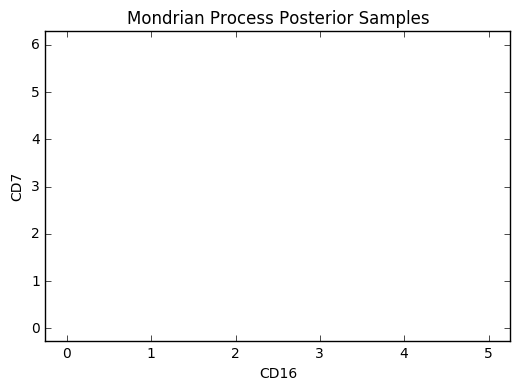

In [161]:
# get an average model
burnt_accepts = np.array([_ for chain in accepts for _ in chain[len(chain)*8/11:]])

colors = ['r','k','g']
def print_partitions(p, trans_level=1., color='k'):
    if not p[1] and not p[2]: 
        plt.plot([p[0][0,0], p[0][0,0]], [p[0][1,0], p[0][1,1]], color+'-', linewidth=5, alpha=trans_level)
        plt.plot([p[0][0,1], p[0][0,1]], [p[0][1,0], p[0][1,1]], color+'-', linewidth=5, alpha=trans_level)
        plt.plot([p[0][0,0], p[0][0,1]], [p[0][1,0], p[0][1,0]], color+'-', linewidth=5, alpha=trans_level)
        plt.plot([p[0][0,0], p[0][0,1]], [p[0][1,1], p[0][1,1]], color+'-', linewidth=5, alpha=trans_level)
    
    else:
        print_partitions(p[1], trans_level, color)
        print_partitions(p[2], trans_level, color)

plt.figure()
plt.scatter(data_2d_list[1][:,0], data_2d_list[1][:,1],s=10)
for i in range(1,3):
    print data_2d_list[i].shape
    plt.scatter(data_2d_list[i][:,0], data_2d_list[i][:,1],s = 10)

# #print all samples
# for sample in burnt_accepts:
#     print_partitions(sample, trans_level = 0.005, color='b')
    

plt.xlabel("CD16")
plt.ylabel("CD7")
plt.title("Mondrian Process Posterior Samples")

plt.xlim([x_min, x_max])
plt.ylim([y_min, y_max])
plt.show()

## Experiment #2: 1D Random Effects: real data (AML 2 samples)

In [303]:
# load data into a dictionary of pandas data frames

PATH_DATA = '/extra/disij0/data/flow_cytometry/cytobank/levine_aml/CSV/'
#PATH = '/Users/disiji/Dropbox/current/flow_cytometry/acdc/data/'

user_ids = ['H1','H2','H3','H4','H5','SJ01','SJ02','SJ03','SJ04','SJ05','SJ06','SJ07','SJ08','SJ09','SJ10',\
           'SJ11','SJ12','SJ13','SJ14','SJ15','SJ16']

data_dict = dict()
for id in user_ids:
    data_path = PATH_DATA + id
    allFiles = glob.glob(data_path + "/*fcsdim_42.csv")
    frame = pd.DataFrame()
    list_ = []
    for file_ in allFiles:
        df = pd.read_csv(file_,index_col=None, header=0)
        list_.append(df)
    data_dict[id] = pd.concat(list_)

In [307]:
n_cells = [data_dict[id].shape[0] for id in user_ids]
print sum(n_cells)/len(n_cells)

730863


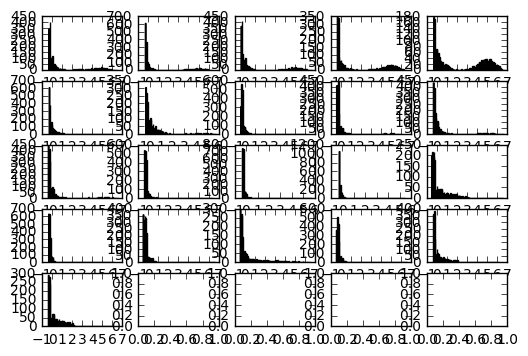

In [139]:
# choose 2 subjects that look best (from the perspective of \
# visualization and demonstrating random effects among different samples)

f = lambda x: np.arcsinh((x -1.)/5.)
markers = ['CD3']

fig, axarr = plt.subplots(5,5)
i = 0
for id in user_ids:
    axarr[i/5, i%5].hist(data_dict[id].head(2000).applymap(f)[markers].values,bins = 100)
    i += 1
plt.show()

In [140]:
table_1d = table[['CD3']]
print table_1d

theta_space_1d = np.array([[np.concatenate(data_CD3).min(),np.concatenate(data_CD3).max()]])

                        CD3
Basophils                -1
CD4 T cells               1
CD8 T cells               1
CD16- NK cells           -1
CD16+ NK cells           -1
CD34+CD38+CD123- HSPCs   -1
CD34+CD38+CD123+ HSPCs   -1
CD34+CD38lo HSCs         -1
Mature B cells           -1
Plasma B cells           -1
Pre B cells              -1
Pro B cells              -1
Monocytes                -1
pDCs                     -1


In [141]:
def cut_pos_1d(mp_sample):
    return mp_sample[1][0][0][1]

In [174]:
# decide to pick 3 subjects
subjects = ['H3','H5']
data_CD3 = [data_dict[id].head(20000).applymap(f)[markers].values for id in subjects]

### fit individual Mondrian processes

In [232]:
# fit individual Mondrian processes

from matplotlib import collections  as mc

mp_samples = [None for _ in subjects]
cuts_single = [None for _ in subjects]

n_iter = 1000
mcmc_gaussin_std = 0.1
n_chains = 10

for i in range(len(subjects)):
    mp_samples[i] = [init_mp(theta_space_1d, table_1d, data_CD3[i], n_iter,mcmc_gaussin_std) for _ in range(n_chains)]
    cuts_single[i] = [cut_pos_1d(_) for _ in mp_samples[i]]
    cuts_single[i] = [[[pos,0],[pos,20000]] for pos in cuts_single[i]]

### fit grouped Mondrian processes

In [233]:
def mcmc_template(data, chain, theta_space, table, mcmc_gaussin_std = 0.1,n_mcmc_sample=1000,random_effect_gaussian_std = 0.01):
    
    n_samples = len(data)
    pooled_data = np.concatenate(data)
    
    np.random.seed(chain)    
    
    accepts_template_mp_chain = []
    accepts_indiv_mp_lists_chain = [[] for i in range(n_samples)]
    joint_logP_chain = []
    
    ### INITIALIZE template_mp AND indivi_mp_list
    print "Initializing template mondrian process with pooled data"
    template_mp = init_mp(theta_space, table, pooled_data, 100, mcmc_gaussin_std)
    indiv_mp_list = [np.copy(template_mp) for _ in range(n_samples)] 
    accepts_template_mp_chain.append(template_mp)

    for idx in xrange(n_mcmc_sample):
        if idx == n_mcmc_sample / 3:
            mcmc_gaussin_std  = mcmc_gaussin_std / 5
        
        # update indiv mondrian processes of each sample
        for _ in range(n_samples):
            new_sample = Mondrian_Gaussian_perturbation(
                            theta_space,indiv_mp_list[_], mcmc_gaussin_std)
 
            log_p = joint_logP_Random_Effect(template_mp, \
                    [indiv_mp_list[_]],[data[_]], table, random_effect_gaussian_std)
            new_log_p = joint_logP_Random_Effect(template_mp, \
                    [new_sample],[data[_]], table, random_effect_gaussian_std)
        
            
            if new_log_p >  log_p or \
            np.log(np.random.uniform(low=0, high=1.)) < new_log_p - log_p:
                indiv_mp_list[_] = new_sample
                accepts_indiv_mp_lists_chain[_].append(new_sample)
                
                
        # update template mondrian process
        new_sample = Mondrian_Gaussian_perturbation(
                    theta_space, template_mp, mcmc_gaussin_std)
        
        log_p = joint_logP_Random_Effect(template_mp, indiv_mp_list, 
                [np.empty((0,table.shape[1])) for _ in range(n_samples)],\
                table, random_effect_gaussian_std)

        new_log_p = joint_logP_Random_Effect(new_sample, indiv_mp_list, 
                [np.empty((0,table.shape[1])) for _ in range(n_samples)],\
                table, random_effect_gaussian_std)
        
        if new_log_p >  log_p or \
        np.log(np.random.uniform(low=0, high=1.)) < new_log_p - log_p:
            template_mp = new_sample
            accepts_template_mp_chain.append(template_mp)
            
        joint_logP_chain.append(joint_logP_Random_Effect(template_mp, indiv_mp_list, \
                                data, table, random_effect_gaussian_std))

        if (idx + 1) % (n_mcmc_sample/4) == 0:
            print "Chain %d: Drawing Sample %d ..." % (chain, idx + 1)
            print "Accepted proposals of indiv mp, template mp: %d, %d, %d" \
                    % (len(accepts_indiv_mp_lists_chain[0]), \
                       len(accepts_indiv_mp_lists_chain[1]), \
                       len(accepts_template_mp_chain))
                
    return accepts_template_mp_chain,accepts_indiv_mp_lists_chain,joint_logP_chain

In [234]:
from joblib import Parallel, delayed
import multiprocessing

num_cores = multiprocessing.cpu_count()
results = Parallel(n_jobs=num_cores)(delayed(mcmc_template)(data_CD3, i, theta_space_1d, \
                table_1d,random_effect_gaussian_std = 0.001) for i in range(n_chains))

accepts_template_mp = []
accepts_indiv_mp_lists = []

for _ in results:
    accepts_template_mp.append(_[0])
    accepts_indiv_mp_lists.append(_[1])

Initializing template mondrian process with pooled data
Initializing template mondrian process with pooled data
Initializing template mondrian process with pooled data
Initializing template mondrian process with pooled data
Initializing template mondrian process with pooled data
Initializing template mondrian process with pooled data
Initializing template mondrian process with pooled data
Initializing template mondrian process with pooled data
Initializing template mondrian process with pooled data
Initializing template mondrian process with pooled data
Chain 5: Drawing Sample 250 ...
Accepted proposals of indiv mp, template mp: 4, 8, 6
Chain 1: Drawing Sample 250 ...
Accepted proposals of indiv mp, template mp: 3, 3, 9
Chain 7: Drawing Sample 250 ...
Accepted proposals of indiv mp, template mp: 8, 4, 10
Chain 8: Drawing Sample 250 ...
Accepted proposals of indiv mp, template mp: 2, 4, 6
Chain 6: Drawing Sample 250 ...
Accepted proposals of indiv mp, template mp: 6, 4, 5
Chain 9: Drawi

In [235]:
cuts_grouped = [None for _ in range(len(subjects)+1)]

for id in range(len(subjects)):
    burnt_samples = [i for _ in range(len(results)) for i in \
                     accepts_indiv_mp_lists[_][id][-1:]]
    cuts_grouped[id] = [cut_pos_1d(_) for _ in burnt_samples]
    cuts_grouped[id] = [[[pos,0],[pos,20000]] for pos in cuts_grouped[id]]

burnt_samples = [i for _ in range(len(results)) for i in \
                     accepts_template_mp[_][-1:]]
cuts_grouped[-1] = [cut_pos_1d(_) for _ in burnt_samples]
cuts_grouped[-1] = [[[pos,0],[pos,20000]] for pos in cuts_grouped[-1]]

(40000, 1)
(40000, 1)


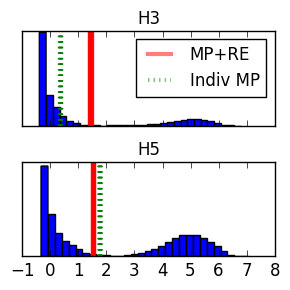

In [298]:
fig,axarr = plt.subplots(len(subjects),1,figsize=(3,3),sharex=True)
bins = 30

for i in range(len(subjects)):
    print np.concatenate(data_CD3).shape
    lines_single = mc.LineCollection(cuts_single[i], linewidths=3, \
                                          alpha = 0.50, color='green',linestyle = ':')
    lines_grouped = mc.LineCollection(cuts_grouped[i], linewidths=3, \
                                            alpha = 0.5, color='red',linestyle = '-')
    axarr[i].hist(data_CD3[i],bins = bins,color ='blue');
    axarr[i].set_title(subjects[i],fontsize=12)
    axarr[i].add_collection(lines_single)
    axarr[i].add_collection(lines_grouped)
    axarr[i].yaxis.set_visible(False)

axarr[0].legend((lines_grouped, lines_single), ("MP+RE","Indiv MP"),fontsize = 12)
plt.xticks(fontsize=12)
# axarr[i].plot([], c='green', label='Indiv MP')
# axarr[i].plot([], c='red', label='MP+RE')
plt.tight_layout()
plt.savefig('random_effect_1D.png')
    
# axarr[-1].hist(np.concatenate(data_CD3),bins = bins)
# axarr[-1].set_title('Pooled data')
# axarr[-1].add_collection(mc.LineCollection(cuts_grouped[-1], linewidths=5, \
#                                       alpha = 1.0, color = 'red',linestyle = '-'))
# axarr[-1].yaxis.set_visible(False)

## Experiment #3: 2D Random Effect: simulated data

Now run MCMC to collect posterior samples...

Initializing template mondrian process with pooled data


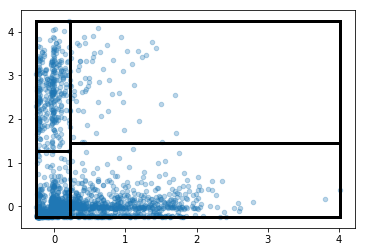

Drawing Chain 0 ...
Drawing Sample 100 ...
Acceptence rate of indiv mp, template mp: 0.21, 0.22, 0.32 
Drawing Sample 200 ...
Acceptence rate of indiv mp, template mp: 0.20, 0.17, 0.40 
Drawing Sample 300 ...
Acceptence rate of indiv mp, template mp: 0.16, 0.12, 0.36 
Drawing Sample 400 ...
Acceptence rate of indiv mp, template mp: 0.12, 0.09, 0.34 
Drawing Sample 500 ...
Acceptence rate of indiv mp, template mp: 0.10, 0.08, 0.34 
Drawing Sample 600 ...
Acceptence rate of indiv mp, template mp: 0.10, 0.07, 0.34 
Drawing Sample 700 ...
Acceptence rate of indiv mp, template mp: 0.09, 0.06, 0.33 
Drawing Sample 800 ...
Acceptence rate of indiv mp, template mp: 0.08, 0.06, 0.32 
Drawing Sample 900 ...
Acceptence rate of indiv mp, template mp: 0.07, 0.05, 0.31 
Drawing Sample 1000 ...
Acceptence rate of indiv mp, template mp: 0.07, 0.05, 0.31 


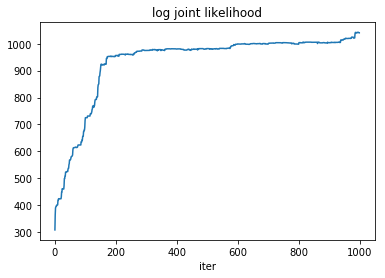

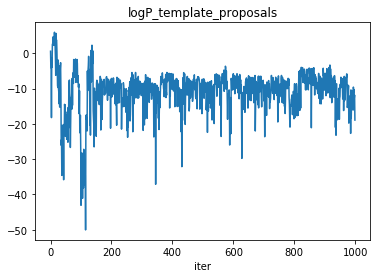

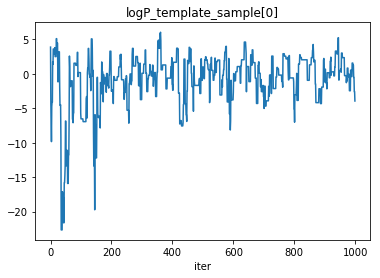

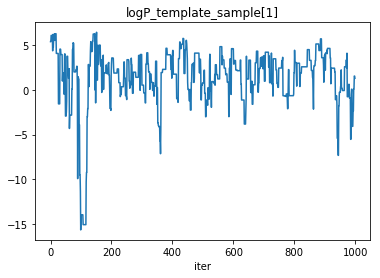

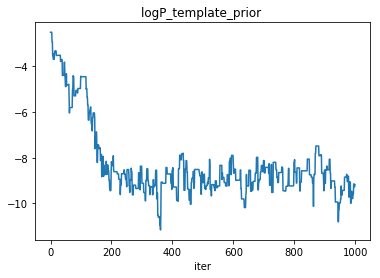

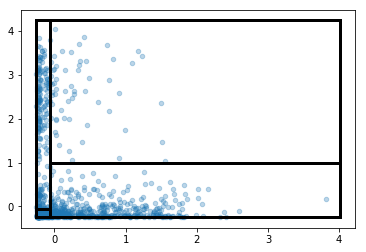

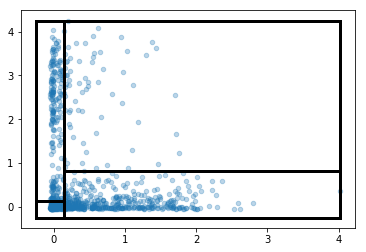

CPU times: user 2min 28s, sys: 1.84 s, total: 2min 30s
Wall time: 1min 26s


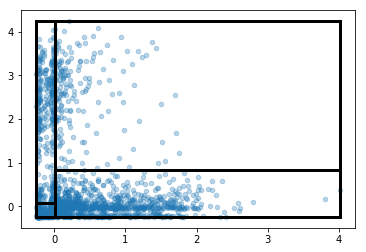

In [244]:
%%time

n_mcmc_chain = 1
n_mcmc_sample = 1000
mcmc_gaussin_std = 0.01

accepte_count_indiv = [0 for _ in range(n_samples)]
accepte_count_template = 0
joint_logP = []
logP_template_proposals = []
logP_template_prior = []
logP_template_sample = [[] for _ in range(n_samples)]

for chain in range(n_mcmc_chain):
    ### INITIALIZE template_mp AND indivi_mp_list
    print "Initializing template mondrian process with pooled data"
    pooled_data = np.concatenate(samples_2d)
    template_mp = init_mp(theta_space_2d, table_2d, pooled_data, 100,mcmc_gaussin_std)
    indiv_mp_list = [np.copy(template_mp) for _ in range(n_samples)] 
    
    plt.scatter(pooled_data[:,0], pooled_data[:,1] ,s=20, alpha = 0.3)
    print_partitions(template_mp)
    plt.show()
    
    if chain % 5 == 0:
        print "Drawing Chain %d ..." % chain
    
    for idx in xrange(n_mcmc_sample):
        
        # update indiv mondrian processes of each sample
        for _ in range(n_samples):
            new_sample = Mondrian_Gaussian_perturbation(
                            theta_space_2d,indiv_mp_list[_], mcmc_gaussin_std)
 
            log_p = joint_logP_Random_Effect(
                        template_mp, [indiv_mp_list[_]],[samples_2d[_]], table_2d, mcmc_gaussin_std)
            new_log_p = joint_logP_Random_Effect(
                        template_mp, [new_sample],[samples_2d[_]], table_2d, mcmc_gaussin_std)
        
            
            if new_log_p >  log_p or \
            np.log(np.random.uniform(low=0, high=1.)) < new_log_p - log_p:
                indiv_mp_list[_] = new_sample
                accepte_count_indiv[_] += 1
                
        # update template mondrian process
        new_sample = Mondrian_Gaussian_perturbation(
                    theta_space_2d, template_mp, mcmc_gaussin_std)
        
        log_p = joint_logP_Random_Effect(template_mp, indiv_mp_list, 
                [np.empty((0,table_2d.shape[1])) for _ in range(n_samples)], table_2d, mcmc_gaussin_std)

        new_log_p = joint_logP_Random_Effect(new_sample, indiv_mp_list, 
                [np.empty((0,table_2d.shape[1])) for _ in range(n_samples)], table_2d, mcmc_gaussin_std)
        
        logP_template_proposals.append(new_log_p)
        logP_template_sample[0].append(logP_Mondrian_Gaussian_perturbation(indiv_mp_list[0],template_mp,mcmc_gaussin_std))
        logP_template_sample[1].append(logP_Mondrian_Gaussian_perturbation(indiv_mp_list[1],template_mp,mcmc_gaussin_std))
        logP_template_prior.append(comp_log_p_prior(template_mp, table_2d, [1 for _ in range(table_2d.shape[1])]))
        
        if new_log_p >  log_p or \
        np.log(np.random.uniform(low=0, high=1.)) < new_log_p - log_p:
            template_mp = new_sample
            accepte_count_template  +=  1
            
        joint_logP.append(joint_logP_Random_Effect(
                template_mp, indiv_mp_list, samples_2d, table_2d, mcmc_gaussin_std))
        
            
        if (idx + 1) % 100 == 0:
            print "Drawing Sample %d ..." % (idx + 1)
            print "Acceptence rate of indiv mp, template mp: %.2f, %.2f, %.2f " \
                    % (accepte_count_indiv[0]*1.0/(idx+1), accepte_count_indiv[1]*1.0/(idx+1),\
                       accepte_count_template*1.0/(idx+1))
#             print "prior probability of the indiv mp: %.2f, %.2f" % \
#                     (comp_log_p_prior(indiv_mp_list[0], table_2d, [1 for _ in range(table_2d.shape[1])]),\
#                     comp_log_p_prior(indiv_mp_list[1], table_2d, [1 for _ in range(table_2d.shape[1])]))
#             print "prior probability of the template: %.2f" % \
#                     comp_log_p_prior(template_mp, table_2d, [1 for _ in range(table_2d.shape[1])])
#             print "log likelihood of indiv mp given the template: %.2f, %.2f" % \
#                     ( logP_Mondrian_Gaussian_perturbation(indiv_mp_list[0],template_mp,mcmc_gaussin_std),\
#                      logP_Mondrian_Gaussian_perturbation(indiv_mp_list[1],template_mp,mcmc_gaussin_std))
                
                
plt.plot(joint_logP)
plt.xlabel("iter")
plt.title("log joint likelihood")
plt.show()

plt.plot(logP_template_proposals)
plt.xlabel("iter")
plt.title("logP_template_proposals")
plt.show()

plt.plot(logP_template_sample[0])
plt.xlabel("iter")
plt.title("logP_template_sample[0]")
plt.show()

plt.plot(logP_template_sample[1])
plt.xlabel("iter")
plt.title("logP_template_sample[1]")
plt.show()

plt.plot(logP_template_prior)
plt.xlabel("iter")
plt.title("logP_template_prior ")
plt.show()
            
plt.scatter(samples_2d[0][:,0], samples_2d[0][:,1],  s=20, alpha=.3)
print_partitions(indiv_mp_list[0])
plt.show()

plt.scatter(samples_2d[1][:,0], samples_2d[1][:,1],  s=20, alpha=.3)
print_partitions(indiv_mp_list[1])
plt.show()

plt.scatter(pooled_data[:,0], pooled_data[:,1] ,s=20, alpha = .3)
print_partitions(template_mp)